# Link prediction of researchers

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import re
import csv
import json
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.feature_extraction import DictVectorizer
from node2vec import Node2Vec
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

## Load training (with false samples), dev and test sets

In [2]:
node_pairs = []

with open("Data/train.txt") as f:
    for line in f:
        n_nodes = line.strip().split()[0]
        nodes = line.strip().split()[1:]
        for node in nodes:
            if (node, n_nodes) not in node_pairs and (n_nodes, node) not in node_pairs and node != n_nodes:
            #if node != n_nodes:
                node_pairs.append((n_nodes, node))
            
node_list_1 = [i[0] for i in node_pairs]
node_list_2 = [i[1] for i in node_pairs]
n_node = max([int(i) for i in (node_list_1+node_list_2)]) + 1
            
train_original_df = pd.DataFrame({"node_1": node_list_1, "node_2": node_list_2, "link": 1})

In [3]:
train_original_df.shape

(23850, 3)

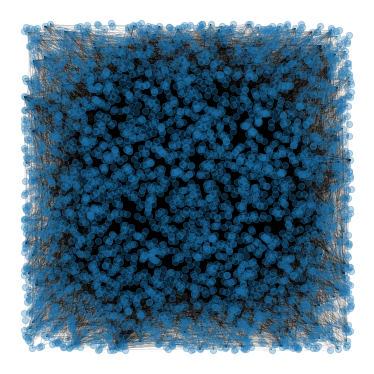

In [4]:
G = nx.from_pandas_edgelist(train_original_df, "node_1", "node_2", create_using=nx.Graph())
plt.figure(figsize=(5,5))
pos = nx.random_layout(G, seed=1)
nx.draw(G, with_labels=False, pos=pos, node_size=40, alpha=0.3, width=0.2)
plt.show()

In [5]:
all_nodes = list(dict.fromkeys(node_list_1+node_list_2))

adj_G = np.zeros((n_node, n_node))
for row in train_original_df.itertuples():
    adj_G[int(row.node_1), int(row.node_2)] = 1

In [6]:
check2 = []

with open("Data/dev.csv") as f:
    reader = csv.reader(f)
    for line in reader:
        check2.append((line[0], line[1]))
        
with open("Data/test-public.csv") as f:
    reader = csv.reader(f)
    for line in reader:
        check2.append((line[0], line[1]))
        
check2 = set(check2)

In [7]:
false_edges = []
with tqdm(total=11925) as pbar:
    while len(false_edges) < 11925:
        a = np.random.randint(0, n_node)
        b = np.random.randint(0, n_node)
        if adj_G[a, b] == 0 and (str(a), str(b)) not in false_edges and (str(b), str(a)) not in false_edges and a!=b:
            if (str(a), str(b)) not in check2 and (str(b), str(a)) not in check2:
                if str(a) in all_nodes and str(b) in all_nodes:
                    if nx.has_path(G, str(a), str(b)) and nx.shortest_path_length(G, str(a), str(b)) <= 2:
                        false_edges.append((str(a), str(b)))
                        pbar.update(1)

with tqdm(total=11925) as pbar:
    while len(false_edges) < 23850:
        a = np.random.randint(0, n_node)
        b = np.random.randint(0, n_node)
        if adj_G[a, b] == 0 and (str(a), str(b)) not in false_edges and (str(b), str(a)) not in false_edges and a!=b:
            if (str(a), str(b)) not in check2 and (str(b), str(a)) not in check2:
                if str(a) in all_nodes and str(b) in all_nodes:
                    if nx.has_path(G, str(a), str(b)) and nx.shortest_path_length(G, str(a), str(b)) >= 4:
                        false_edges.append((str(a), str(b)))
                        pbar.update(1)
                
with open("Data/combined_false.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(false_edges)
    
false_edges_1 = [i[0] for i in false_edges]
false_edges_2 = [i[1] for i in false_edges]
false_df = pd.DataFrame({"node_1": false_edges_1, "node_2": false_edges_2, "link": 0})

100%|███████████████████████████████████████████████████████████████████████████| 11925/11925 [00:34<00:00, 345.06it/s]


In [8]:
unconnected_list_1 = []
unconnected_list_2 = []

with open("Data/combined_false.csv") as f:
    reader = csv.reader(f)
    for line in reader:
        unconnected_list_1.append(line[0])
        unconnected_list_2.append(line[1])

unconnected_df = pd.DataFrame({"node_1": unconnected_list_1, "node_2": unconnected_list_2, "link": 0}).drop_duplicates()
unconnected_df.shape

(23850, 3)

In [9]:
train_df = train_original_df.append(unconnected_df[["node_1", "node_2", "link"]], ignore_index=True)
train_df.shape

(47700, 3)

In [10]:
dev_list_1 = []
dev_list_2 = []
dev_label = []

with open("Data/dev.csv") as f:
    reader = csv.reader(f)
    next(reader)
    for line in reader:
        dev_list_1.append(line[1])
        dev_list_2.append(line[2])

with open("Data/dev-labels.csv") as f:
    reader = csv.reader(f)
    next(reader)
    for line in reader:
        if line[1] == "1":
            dev_label.append(1)
        else:
            dev_label.append(0)
        
dev_df = pd.DataFrame({"node_1": dev_list_1, "node_2": dev_list_2, "link": dev_label})

In [11]:
test_list_1 = []
test_list_2 = []

with open("Data/test-public.csv") as f:
    reader = csv.reader(f)
    next(reader)
    for line in reader:
        test_list_1.append(line[1])
        test_list_2.append(line[2])
        
test_df = pd.DataFrame({"node_1": test_list_1, "node_2": test_list_2})

## Prepare topological features and node features

In [12]:
DIM = 5

node2vec = Node2Vec(G, dimensions=DIM, walk_length=32, num_walks=50, p=1, q=1)
n2w_model = node2vec.fit(window=16, min_count=1)

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 50/50 [04:03<00:00,  4.86s/it]


In [13]:
with open("Data/nodes.json") as f:
    features = json.load(f)
    
selected = ["first", "last", "num_papers"]
keyword = dict()
venue = dict()
publish = dict()

for i in range(n_node):
    keyword[i] = {k:v for k,v in features[i].items() if re.search(r"^keyword_.+$", k)}
    venue[i] = {k:v for k,v in features[i].items() if re.search(r"^venue_.+$", k)}
    publish[i] = {k:v for k,v in features[i].items() if k in selected}
    
keyword = list(keyword.values())
venue = list(venue.values())
publish = list(publish.values())

v = DictVectorizer()
keyword_v = v.fit_transform(keyword)
venue_v = v.fit_transform(venue)
publish_v = v.fit_transform(publish)

print(keyword_v.A.shape, venue_v.A.shape, publish_v.A.shape)

(3929, 53) (3929, 303) (3929, 3)


## Add features to training, dev and test sets

In [14]:
add_node_features = False

In [15]:
x_train = []

for idx, (i, j) in tqdm(enumerate(zip(train_df["node_1"], train_df["node_2"]))):
    temp = np.zeros(DIM)
    temp += n2w_model[i]
    temp = np.append(temp, n2w_model[j])
    temp = np.append(temp, len(list(nx.common_neighbors(G, i, j))))
    temp = np.append(temp, list(nx.resource_allocation_index(G, [(i, j)]))[0][2])
    temp = np.append(temp, list(nx.adamic_adar_index(G, [(i, j)]))[0][2])
    temp = np.append(temp, list(nx.jaccard_coefficient(G, [(i, j)]))[0][2])    
    if add_node_features:
        n_same_keyword = sum([x==1 and y==1 for x, y in zip(keyword_v.A[int(i)], keyword_v.A[int(j)])])
        n_same_venue = sum([x==1 and y==1 for x, y in zip(venue_v.A[int(i)], venue_v.A[int(j)])])
        temp = np.append(temp, n_same_keyword)
        temp = np.append(temp, n_same_venue)
        temp = np.append(temp, publish_v.A[int(i)])
        temp = np.append(temp, publish_v.A[int(j)])
        temp = np.append(temp, keyword_v.A[int(i)])
        temp = np.append(temp, keyword_v.A[int(j)])
    x_train.append(temp)

x_train = np.array(x_train)
y_train = train_df["link"]
x_train.shape

47700it [00:17, 2671.89it/s]


(47700, 14)

In [16]:
APPROX_MEAN_N2V = np.mean(x_train, axis=0)[:(DIM*2)]
n2v_param_n = len(APPROX_MEAN_N2V)

In [17]:
x_dev = []

for i, j in tqdm(zip(dev_df["node_1"], dev_df["node_2"])):
    temp = np.zeros(DIM)
    
    try:
        temp += n2w_model[i]
    except:
        temp += APPROX_MEAN_N2V[:int(n2v_param_n/2)]
    try:
        temp = np.append(temp, n2w_model[j])
    except:
        temp = np.append(temp, APPROX_MEAN_N2V[int(n2v_param_n/2):])
    try:
        temp = np.append(temp, len(list(nx.common_neighbors(G, i, j))))
    except:
        temp = np.append(temp, np.mean(x_train, axis=0)[-4])
    try:
        temp = np.append(temp, list(nx.resource_allocation_index(G, [(i, j)]))[0][2])
    except:
        temp = np.append(temp, np.mean(x_train, axis=0)[-3])
    try:
        temp = np.append(temp, list(nx.adamic_adar_index(G, [(i, j)]))[0][2])
    except:
        temp = np.append(temp, np.mean(x_train, axis=0)[-2])  
    try:
        temp = np.append(temp, list(nx.jaccard_coefficient(G, [(i, j)]))[0][2])
    except:
        temp = np.append(temp, np.mean(x_train, axis=0)[-1])  
    if add_node_features:
        n_same_keyword = sum([x==1 and y==1 for x, y in zip(keyword_v.A[int(i)], keyword_v.A[int(j)])])
        n_same_venue = sum([x==1 and y==1 for x, y in zip(venue_v.A[int(i)], venue_v.A[int(j)])])
        temp = np.append(temp, n_same_keyword)
        temp = np.append(temp, n_same_venue)
        temp = np.append(temp, publish_v.A[int(i)])
        temp = np.append(temp, publish_v.A[int(j)])
        temp = np.append(temp, keyword_v.A[int(i)])
        temp = np.append(temp, keyword_v.A[int(j)])
    x_dev.append(temp)
    
x_dev = np.array(x_dev)
y_dev = dev_df["link"]
x_dev.shape

4866it [00:01, 2553.10it/s]


(4866, 14)

## Model selection and hyperparameter tuning

##### Logistic regression

In [18]:
lr = LogisticRegression(max_iter=1000)
lr.fit(x_train, y_train)

LogisticRegression(max_iter=1000)

In [19]:
predictions = lr.predict_proba(x_dev)
aaa = []
for i in list(predictions[:, 1]):
    if i > 0.5:
        aaa.append(1)
    else:
        aaa.append(0)
aaa = np.array(aaa)
print(roc_auc_score(y_dev, predictions[:, 1]))
print(classification_report(y_dev, aaa))
print(sum(aaa>0.5)/4866)

0.7058254521631849
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      2433
           1       0.97      0.15      0.27      2433

    accuracy                           0.57      4866
   macro avg       0.76      0.57      0.48      4866
weighted avg       0.76      0.57      0.48      4866

0.07912042745581586


##### LightGBM

In [20]:
import lightgbm as lgbm

train_data = lgbm.Dataset(x_train, y_train)
test_data = lgbm.Dataset(x_dev, y_dev)

parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.6,
    'bagging_fraction': 1,
    'bagging_freq': 20,
    'num_threads' : 4,
    'num_leaves': 158,
    'min_child_samples': 20,
    'seed': 10
}

model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=50)

[1]	valid_0's auc: 0.629208
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.636319
[3]	valid_0's auc: 0.677514
[4]	valid_0's auc: 0.689493
[5]	valid_0's auc: 0.691972
[6]	valid_0's auc: 0.716059
[7]	valid_0's auc: 0.724297
[8]	valid_0's auc: 0.725493
[9]	valid_0's auc: 0.721359
[10]	valid_0's auc: 0.723072
[11]	valid_0's auc: 0.721167
[12]	valid_0's auc: 0.717592
[13]	valid_0's auc: 0.719272
[14]	valid_0's auc: 0.720361
[15]	valid_0's auc: 0.720146
[16]	valid_0's auc: 0.724454
[17]	valid_0's auc: 0.722555
[18]	valid_0's auc: 0.725689
[19]	valid_0's auc: 0.731747
[20]	valid_0's auc: 0.733941
[21]	valid_0's auc: 0.736678
[22]	valid_0's auc: 0.738852
[23]	valid_0's auc: 0.741439
[24]	valid_0's auc: 0.741294
[25]	valid_0's auc: 0.742865
[26]	valid_0's auc: 0.74554
[27]	valid_0's auc: 0.743616
[28]	valid_0's auc: 0.743549
[29]	valid_0's auc: 0.743871
[30]	valid_0's auc: 0.743957
[31]	valid_0's auc: 0.746826
[32]	valid_0's auc: 0.747104
[33]	valid_0's auc: 0

[289]	valid_0's auc: 0.778696
[290]	valid_0's auc: 0.778593
[291]	valid_0's auc: 0.778529
[292]	valid_0's auc: 0.778161
[293]	valid_0's auc: 0.778093
[294]	valid_0's auc: 0.777978
[295]	valid_0's auc: 0.777875
[296]	valid_0's auc: 0.777874
[297]	valid_0's auc: 0.777796
[298]	valid_0's auc: 0.777936
[299]	valid_0's auc: 0.77791
[300]	valid_0's auc: 0.778037
[301]	valid_0's auc: 0.778145
[302]	valid_0's auc: 0.77832
[303]	valid_0's auc: 0.778315
[304]	valid_0's auc: 0.778504
[305]	valid_0's auc: 0.778102
[306]	valid_0's auc: 0.778132
[307]	valid_0's auc: 0.777815
[308]	valid_0's auc: 0.777902
[309]	valid_0's auc: 0.777918
[310]	valid_0's auc: 0.7781
[311]	valid_0's auc: 0.778123
Early stopping, best iteration is:
[261]	valid_0's auc: 0.778797


In [21]:
pred = model.predict(x_dev, predict_contrib=True)
print(roc_auc_score(y_train, model.predict(x_train)))
print(roc_auc_score(y_dev, pred))

0.9999987623555678
0.7787969535883924


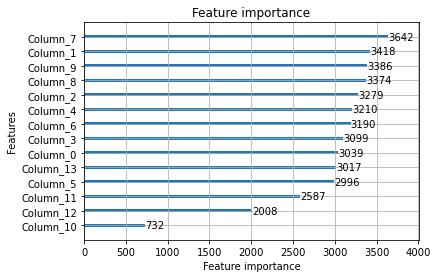

In [22]:
lgbm.plot_importance(model)

In [23]:
bbb=[]

for i in list(pred):
    if i > 0.5:
        bbb.append(1)
    else:
        bbb.append(0)
        
bbb = np.array(bbb)
   
print(classification_report(list(y_dev), bbb))
print(sum(bbb>0.5)/4866)

              precision    recall  f1-score   support

           0       0.56      0.98      0.71      2433
           1       0.92      0.22      0.35      2433

    accuracy                           0.60      4866
   macro avg       0.74      0.60      0.53      4866
weighted avg       0.74      0.60      0.53      4866

0.11960542540073983


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

In [25]:
x_train_reshaped = x_train.reshape(-1, x_train.shape[1], 1)
x_dev_reshaped = x_dev.reshape(-1, x_dev.shape[1], 1)

In [26]:
model_ffnn = Sequential()
model_ffnn.add(Flatten(input_shape=(x_train.shape[1], 1)))
model_ffnn.add(Dense(128, activation="relu"))
model_ffnn.add(Dense(256, activation="relu"))
model_ffnn.add(Dropout(0.5))
model_ffnn.add(Dense(1, activation="sigmoid"))

#model_ffnn.summary()

model_ffnn.compile(loss="binary_crossentropy",
              #optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              optimizer="adam",
              metrics=["accuracy"])
model_ffnn.fit(x_train_reshaped, y_train, epochs=5, batch_size=64)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
47700/47700 [==============================] - 2s 34us/sample - loss: 0.3034 - acc: 0.8774
Epoch 2/5
47700/47700 [==============================] - 2s 32us/sample - loss: 0.2610 - acc: 0.8992
Epoch 3/5
47700/47700 [==============================] - 2s 32us/sample - loss: 0.2481 - acc: 0.9048
Epoch 4/5
47700/47700 [==============================] - 1s 30us/sample - loss: 0.2394 - acc: 0.9083
Epoch 5/5
47700/47700 [==============================] - 1s 30us/sample - loss: 0.2334 - acc: 0.9112


In [27]:
print(roc_auc_score(y_train, model_ffnn.predict(x_train_reshaped)))
print(roc_auc_score(y_dev, model_ffnn.predict(x_dev_reshaped)))

0.9688185374172085
0.7866342010264737


In [28]:
ddd = []
for i in tqdm(range(10)):
    model_ffnn = Sequential()
    model_ffnn.add(Flatten(input_shape=(x_train.shape[1], 1)))
    model_ffnn.add(Dense(128, activation="relu"))
    model_ffnn.add(Dense(256, activation="relu"))
    model_ffnn.add(Dropout(0.5))
    model_ffnn.add(Dense(1, activation="sigmoid"))
    model_ffnn.compile(loss="binary_crossentropy",
              #optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              optimizer="adam",
              metrics=["accuracy"])
    model_ffnn.fit(x_train_reshaped, y_train, epochs=5, batch_size=64, verbose=0)
    ddd.append(model_ffnn.predict(x_dev_reshaped))

ddd = np.array(ddd)
ANN = np.mean(ddd, axis=0)
print(roc_auc_score(y_train, model_ffnn.predict(x_train_reshaped)))
print(roc_auc_score(y_dev, ANN))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.39s/it]


0.9684018766838514
0.8003101281208562


In [29]:
ccc = []
THRESHOLD = 0.5
for i in list(model_ffnn.predict(x_dev_reshaped)):
    if i > THRESHOLD:
        ccc.append(1)
    else:
        ccc.append(0)
        
ccc = np.array(ccc)
        
print(classification_report(y_dev, ccc))
print(sum(ccc>THRESHOLD)/4866)

              precision    recall  f1-score   support

           0       0.55      0.99      0.71      2433
           1       0.96      0.18      0.30      2433

    accuracy                           0.59      4866
   macro avg       0.75      0.59      0.50      4866
weighted avg       0.75      0.59      0.50      4866

0.09350595972050967


##### XGBoost

In [30]:
import xgboost as xgb

dtrain = xgb.DMatrix(x_train, y_train)
ddev = xgb.DMatrix(x_dev, y_dev)

xgb_param={
           'booster': 'gbtree', 
           'lambda': 7.6275956153167e-07,
           'alpha': 0.02398678967417507, 
           'subsample': 0.8151141370974858,
           'colsample_bynode': 0.4961967526340869, 
           'num_parallel_tree': 177, 
           'max_depth': 9, 'eta': 0.9915555732736909, 
           'gamma': 0.4681980009928838, 
           'grow_policy': 'depthwise', 
           'objective': 'binary:logistic',
           'eval_metric': 'auc'
          }


bst = xgb.train(xgb_param,
                dtrain, 
                evals=[(ddev, "eval")],
                num_boost_round=30,
                early_stopping_rounds=3,
                verbose_eval=1)

[0]	eval-auc:0.71835
Will train until eval-auc hasn't improved in 3 rounds.
[1]	eval-auc:0.73085
[2]	eval-auc:0.74305
[3]	eval-auc:0.75772
[4]	eval-auc:0.76568
[5]	eval-auc:0.77130
[6]	eval-auc:0.77551
[7]	eval-auc:0.77794
[8]	eval-auc:0.78009
[9]	eval-auc:0.78124
[10]	eval-auc:0.78197
[11]	eval-auc:0.78277
[12]	eval-auc:0.78346
[13]	eval-auc:0.78386
[14]	eval-auc:0.78424
[15]	eval-auc:0.78429
[16]	eval-auc:0.78429
[17]	eval-auc:0.78429
[18]	eval-auc:0.78406
[19]	eval-auc:0.78418
[20]	eval-auc:0.78396
Stopping. Best iteration:
[17]	eval-auc:0.78429



In [31]:
print(roc_auc_score(y_train, bst.predict(dtrain)))
print(roc_auc_score(y_dev, bst.predict(ddev)))

0.9993348926949971
0.7839590545737986


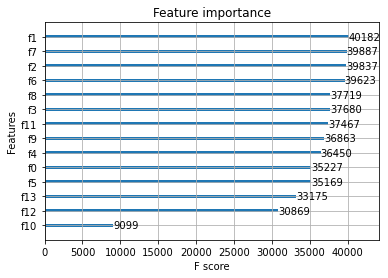

In [32]:
pred_xgb_dev = bst.predict(ddev)
xgb.plot_importance(bst)

In [33]:
ffff = []
THRESHOLD = 0.5
for i in list(bst.predict(ddev)):
    if i > THRESHOLD:
        ffff.append(1)
    else:
        ffff.append(0)
        
ffff = np.array(ffff)
        
print(classification_report(y_dev, ffff))
print(sum(ffff>THRESHOLD)/4866)

              precision    recall  f1-score   support

           0       0.56      0.98      0.71      2433
           1       0.91      0.22      0.36      2433

    accuracy                           0.60      4866
   macro avg       0.74      0.60      0.53      4866
weighted avg       0.74      0.60      0.53      4866

0.12063296341964652


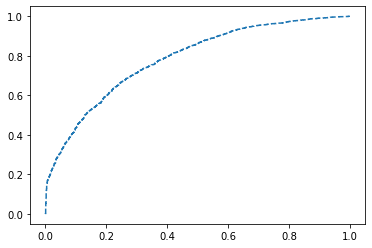

In [34]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_dev, bst.predict(ddev))
plt.plot(fpr, tpr, linestyle='--')

## Fit over train and dev sets and predict for test set

In [35]:
instance_weights = np.array([1]*len(x_train) + [10]*len(x_dev))
pd.value_counts(instance_weights).to_frame().reset_index().sort_values('index')

,index,0
0,1,47700
1,10,4866


In [36]:
train_dev_df = train_df.append(dev_df[["node_1", "node_2", "link"]], ignore_index=True)
print(train_dev_df.shape)

train_dev_clean_df = train_dev_df[train_dev_df.link==1]
print(train_dev_clean_df.shape)

(52566, 3)
(26283, 3)


In [37]:
test_true_df = pd.DataFrame({"node_1": test_df.node_1.values, "node_2": test_df.node_2.values, "link": 1})
train_dev_clean_df = train_dev_clean_df.append(test_true_df[["node_1", "node_2", "link"]], ignore_index=True)
G_full = nx.from_pandas_edgelist(train_dev_clean_df, "node_1", "node_2", create_using=nx.Graph())

node2vec_full = Node2Vec(G_full, dimensions=DIM, walk_length=32, num_walks=50, p=1, q=1)
n2w_model_full = node2vec_full.fit(window=16, min_count=1)

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 50/50 [04:22<00:00,  5.25s/it]


In [38]:
x_train_full = []

for i, j in tqdm(zip(train_dev_df["node_1"], train_dev_df["node_2"])):
    temp = np.zeros(DIM)
    temp += n2w_model_full[i]
    temp = np.append(temp, n2w_model_full[j])
    temp = np.append(temp, len(list(nx.common_neighbors(G_full, i, j))))
    temp = np.append(temp, list(nx.resource_allocation_index(G_full, [(i, j)]))[0][2])
    temp = np.append(temp, list(nx.adamic_adar_index(G_full, [(i, j)]))[0][2])
    temp = np.append(temp, list(nx.jaccard_coefficient(G_full, [(i, j)]))[0][2])
    if add_node_features:
        n_same_keyword = sum([x==1 and y==1 for x, y in zip(keyword_v.A[int(i)], keyword_v.A[int(j)])])
        n_same_venue = sum([x==1 and y==1 for x, y in zip(venue_v.A[int(i)], venue_v.A[int(j)])])
        temp = np.append(temp, n_same_keyword)
        temp = np.append(temp, n_same_venue)
        temp = np.append(temp, publish_v.A[int(i)])
        temp = np.append(temp, publish_v.A[int(j)])
    x_train_full.append(temp)
    
x_train_full = np.array(x_train_full)
y_train_full = train_dev_df["link"]
x_train_full.shape

52566it [00:22, 2337.65it/s]


(52566, 14)

In [39]:
APPROX_MEAN_N2V_full = np.mean(x_train_full, axis=0)[:10]
n2v_param_n_full = len(APPROX_MEAN_N2V_full)

x_test_full = []

for i, j in tqdm(zip(test_df["node_1"], test_df["node_2"])):
    temp = np.zeros(DIM)
    try:
        temp += n2w_model_full[i]
    except:
        temp += APPROX_MEAN_N2V_full[:int(n2v_param_n_full/2)]
    try:
        temp = np.append(temp, n2w_model_full[j])
    except:
        temp = np.append(temp, APPROX_MEAN_N2V_full[int(n2v_param_n_full/2):])
    try:
        temp = np.append(temp, len(list(nx.common_neighbors(G_full, i, j))))
    except:
        temp = np.append(temp, np.mean(x_train_full, axis=0)[-4])
    try:
        temp = np.append(temp, list(nx.resource_allocation_index(G_full, [(i, j)]))[0][2])
    except:
        temp = np.append(temp, np.mean(x_train_full, axis=0)[-3])
    try:
        temp = np.append(temp, list(nx.adamic_adar_index(G_full, [(i, j)]))[0][2])
    except:
        temp = np.append(temp, np.mean(x_train_full, axis=0)[-2])  
    try:
        temp = np.append(temp, list(nx.jaccard_coefficient(G_full, [(i, j)]))[0][2])
    except:
        temp = np.append(temp, np.mean(x_train_full, axis=0)[-1])  
    if add_node_features:
        n_same_keyword = sum([x==1 and y==1 for x, y in zip(keyword_v.A[int(i)], keyword_v.A[int(j)])])
        n_same_venue = sum([x==1 and y==1 for x, y in zip(venue_v.A[int(i)], venue_v.A[int(j)])])
        temp = np.append(temp, n_same_keyword)
        temp = np.append(temp, n_same_venue)
        temp = np.append(temp, publish_v.A[int(i)])
        temp = np.append(temp, publish_v.A[int(j)])
    x_test_full.append(temp)
    
x_test_full = np.array(x_test_full)
x_test_full.shape

4460it [00:01, 2686.59it/s]


(4460, 14)

##### Neural network

In [40]:
x_train_full_reshaped = x_train_full.reshape(-1, x_train_full.shape[1], 1)
x_test_full_reshaped = x_test_full.reshape(-1, x_test_full.shape[1], 1)

In [41]:
model_ffnn_full = Sequential()
model_ffnn_full.add(Flatten(input_shape=(x_train_full.shape[1], 1)))
model_ffnn_full.add(Dense(128, activation="relu"))
model_ffnn_full.add(Dense(256, activation="relu"))
model_ffnn_full.add(Dropout(0.5))
model_ffnn_full.add(Dense(1, activation="sigmoid"))
#model_ffnn_full.summary()
model_ffnn_full.compile(loss="binary_crossentropy",
              #optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
              optimizer="adam",
              metrics=["accuracy"])
model_ffnn_full.fit(x_train_full_reshaped, y_train_full, epochs=5, batch_size=64)

Epoch 1/5
52566/52566 [==============================] - 2s 34us/sample - loss: 0.3037 - acc: 0.8768
Epoch 2/5
52566/52566 [==============================] - 2s 32us/sample - loss: 0.2652 - acc: 0.8966
Epoch 3/5
52566/52566 [==============================] - 2s 39us/sample - loss: 0.2528 - acc: 0.9036
Epoch 4/5
52566/52566 [==============================] - 2s 44us/sample - loss: 0.2462 - acc: 0.9064
Epoch 5/5
52566/52566 [==============================] - 2s 44us/sample - loss: 0.2429 - acc: 0.9084


In [42]:
eee = []

for i in tqdm(range(20)):
    model_ffnn_full = Sequential()
    model_ffnn_full.add(Flatten(input_shape=(x_train_full.shape[1], 1)))
    model_ffnn_full.add(Dense(128, activation="relu"))
    model_ffnn_full.add(Dense(256, activation="relu"))
    model_ffnn_full.add(Dropout(0.5))
    model_ffnn_full.add(Dense(1, activation="sigmoid"))
    #model_ffnn_full.summary()
    model_ffnn_full.compile(loss="binary_crossentropy",
                  #optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
                  optimizer="adam",
                  metrics=["accuracy"])
    model_ffnn_full.fit(x_train_full_reshaped, y_train_full, epochs=5, batch_size=64, sample_weight=instance_weights)
    eee.append(model_ffnn_full.predict(x_test_full_reshaped))
    
eee = np.array(eee)
ANN_test = np.mean(eee, axis=0)
print(roc_auc_score(y_train_full, model_ffnn_full.predict(x_train_full_reshaped)))

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch 1/5
52566/52566 [==============================] - 2s 47us/sample - loss: 0.5359 - acc: 0.8665
Epoch 2/5
52566/52566 [==============================] - 2s 44us/sample - loss: 0.4592 - acc: 0.8825
Epoch 3/5
52566/52566 [==============================] - 2s 44us/sample - loss: 0.4327 - acc: 0.8898
Epoch 4/5
52566/52566 [==============================] - 3s 48us/sample - loss: 0.4136 - acc: 0.8939
Epoch 5/5
52566/52566 [==============================] - 3s 50us/sample - loss: 0.4068 - acc: 0.8976


  5%|████▏                                                                              | 1/20 [00:14<04:27, 14.10s/it]

Epoch 1/5
52566/52566 [==============================] - 3s 51us/sample - loss: 0.5453 - acc: 0.8636
Epoch 2/5
52566/52566 [==============================] - 2s 42us/sample - loss: 0.4550 - acc: 0.8818
Epoch 3/5
52566/52566 [==============================] - 2s 40us/sample - loss: 0.4322 - acc: 0.8890
Epoch 4/5
52566/52566 [==============================] - 2s 40us/sample - loss: 0.4169 - acc: 0.8935
Epoch 5/5
52566/52566 [==============================] - 2s 44us/sample - loss: 0.4050 - acc: 0.8962


 10%|████████▎                                                                          | 2/20 [00:27<04:10, 13.91s/it]

Epoch 1/5
52566/52566 [==============================] - 2s 43us/sample - loss: 0.5307 - acc: 0.8666
Epoch 2/5
52566/52566 [==============================] - 2s 38us/sample - loss: 0.4535 - acc: 0.8843
Epoch 3/5
52566/52566 [==============================] - 2s 38us/sample - loss: 0.4296 - acc: 0.8901
Epoch 4/5
52566/52566 [==============================] - 2s 43us/sample - loss: 0.4103 - acc: 0.8943
Epoch 5/5
52566/52566 [==============================] - 2s 45us/sample - loss: 0.4013 - acc: 0.8981


 15%|████████████▍                                                                      | 3/20 [00:40<03:50, 13.54s/it]

Epoch 1/5
52566/52566 [==============================] - 2s 45us/sample - loss: 0.5394 - acc: 0.8669
Epoch 2/5
52566/52566 [==============================] - 2s 45us/sample - loss: 0.4595 - acc: 0.8812
Epoch 3/5
52566/52566 [==============================] - 2s 46us/sample - loss: 0.4351 - acc: 0.8881
Epoch 4/5
52566/52566 [==============================] - 2s 47us/sample - loss: 0.4183 - acc: 0.8926
Epoch 5/5
52566/52566 [==============================] - 2s 46us/sample - loss: 0.4042 - acc: 0.8967


 20%|████████████████▌                                                                  | 4/20 [00:54<03:41, 13.83s/it]

Epoch 1/5
52566/52566 [==============================] - 3s 48us/sample - loss: 0.5324 - acc: 0.8670
Epoch 2/5
52566/52566 [==============================] - 2s 44us/sample - loss: 0.4582 - acc: 0.8829
Epoch 3/5
52566/52566 [==============================] - 2s 41us/sample - loss: 0.4301 - acc: 0.8896
Epoch 4/5
52566/52566 [==============================] - 2s 44us/sample - loss: 0.4135 - acc: 0.8952
Epoch 5/5
52566/52566 [==============================] - 2s 40us/sample - loss: 0.4026 - acc: 0.8966


 25%|████████████████████▊                                                              | 5/20 [01:08<03:24, 13.67s/it]

Epoch 1/5
52566/52566 [==============================] - 3s 50us/sample - loss: 0.5442 - acc: 0.8661
Epoch 2/5
52566/52566 [==============================] - 2s 42us/sample - loss: 0.4574 - acc: 0.8830
Epoch 3/5
52566/52566 [==============================] - 2s 43us/sample - loss: 0.4274 - acc: 0.8903
Epoch 4/5
52566/52566 [==============================] - 2s 47us/sample - loss: 0.4119 - acc: 0.8955
Epoch 5/5
52566/52566 [==============================] - 2s 44us/sample - loss: 0.4022 - acc: 0.8967


 30%|████████████████████████▉                                                          | 6/20 [01:21<03:11, 13.67s/it]

Epoch 1/5
52566/52566 [==============================] - 3s 52us/sample - loss: 0.5357 - acc: 0.8665
Epoch 2/5
52566/52566 [==============================] - 2s 46us/sample - loss: 0.4547 - acc: 0.8820
Epoch 3/5
52566/52566 [==============================] - 2s 45us/sample - loss: 0.4365 - acc: 0.8897
Epoch 4/5
52566/52566 [==============================] - 2s 45us/sample - loss: 0.4170 - acc: 0.8940
Epoch 5/5
52566/52566 [==============================] - 2s 45us/sample - loss: 0.4076 - acc: 0.8956


 35%|█████████████████████████████                                                      | 7/20 [01:36<03:00, 13.87s/it]

Epoch 1/5
52566/52566 [==============================] - 3s 52us/sample - loss: 0.5341 - acc: 0.8652
Epoch 2/5
52566/52566 [==============================] - 2s 46us/sample - loss: 0.4560 - acc: 0.8813
Epoch 3/5
52566/52566 [==============================] - 2s 46us/sample - loss: 0.4315 - acc: 0.8891
Epoch 4/5
52566/52566 [==============================] - 2s 45us/sample - loss: 0.4106 - acc: 0.8952
Epoch 5/5
52566/52566 [==============================] - ETA: 0s - loss: 0.4030 - acc: 0.896 - 2s 47us/sample - loss: 0.4043 - acc: 0.8965


 40%|█████████████████████████████████▏                                                 | 8/20 [01:50<02:48, 14.06s/it]

Epoch 1/5
52566/52566 [==============================] - 3s 52us/sample - loss: 0.5315 - acc: 0.8661
Epoch 2/5
52566/52566 [==============================] - 2s 38us/sample - loss: 0.4579 - acc: 0.8832
Epoch 3/5
52566/52566 [==============================] - 2s 40us/sample - loss: 0.4323 - acc: 0.8896
Epoch 4/5
52566/52566 [==============================] - 2s 39us/sample - loss: 0.4142 - acc: 0.8943
Epoch 5/5
52566/52566 [==============================] - 2s 41us/sample - loss: 0.4029 - acc: 0.8973


 45%|█████████████████████████████████████▎                                             | 9/20 [02:03<02:32, 13.82s/it]

Epoch 1/5
52566/52566 [==============================] - 3s 53us/sample - loss: 0.5264 - acc: 0.8657
Epoch 2/5
52566/52566 [==============================] - 3s 50us/sample - loss: 0.4570 - acc: 0.8819
Epoch 3/5
52566/52566 [==============================] - 3s 55us/sample - loss: 0.4377 - acc: 0.8881
Epoch 4/5
52566/52566 [==============================] - 3s 52us/sample - loss: 0.4179 - acc: 0.8931
Epoch 5/5
52566/52566 [==============================] - 3s 52us/sample - loss: 0.4066 - acc: 0.8973


 50%|█████████████████████████████████████████                                         | 10/20 [02:19<02:25, 14.52s/it]

Epoch 1/5
52566/52566 [==============================] - 3s 56us/sample - loss: 0.5323 - acc: 0.8661
Epoch 2/5
52566/52566 [==============================] - 3s 50us/sample - loss: 0.4568 - acc: 0.8830
Epoch 3/5
52566/52566 [==============================] - 3s 51us/sample - loss: 0.4343 - acc: 0.8862
Epoch 4/5
52566/52566 [==============================] - 3s 49us/sample - loss: 0.4150 - acc: 0.8933
Epoch 5/5
52566/52566 [==============================] - 3s 55us/sample - loss: 0.4046 - acc: 0.8976


 55%|█████████████████████████████████████████████                                     | 11/20 [02:36<02:16, 15.16s/it]

Epoch 1/5
52566/52566 [==============================] - 3s 56us/sample - loss: 0.5370 - acc: 0.8650
Epoch 2/5
52566/52566 [==============================] - 3s 48us/sample - loss: 0.4572 - acc: 0.8827
Epoch 3/5
52566/52566 [==============================] - 3s 49us/sample - loss: 0.4386 - acc: 0.8871
Epoch 4/5
52566/52566 [==============================] - 3s 52us/sample - loss: 0.4135 - acc: 0.8952
Epoch 5/5
52566/52566 [==============================] - 3s 55us/sample - loss: 0.4057 - acc: 0.8977


 60%|█████████████████████████████████████████████████▏                                | 12/20 [02:53<02:04, 15.61s/it]

Epoch 1/5
52566/52566 [==============================] - 3s 54us/sample - loss: 0.5443 - acc: 0.8648
Epoch 2/5
52566/52566 [==============================] - 3s 52us/sample - loss: 0.4600 - acc: 0.8824
Epoch 3/5
52566/52566 [==============================] - 3s 51us/sample - loss: 0.4388 - acc: 0.8877
Epoch 4/5
52566/52566 [==============================] - 3s 52us/sample - loss: 0.4181 - acc: 0.8922
Epoch 5/5
52566/52566 [==============================] - 3s 48us/sample - loss: 0.4063 - acc: 0.8971


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [03:09<01:51, 15.91s/it]

Epoch 1/5
52566/52566 [==============================] - 3s 56us/sample - loss: 0.5323 - acc: 0.8669
Epoch 2/5
52566/52566 [==============================] - 3s 50us/sample - loss: 0.4554 - acc: 0.8838
Epoch 3/5
52566/52566 [==============================] - 3s 49us/sample - loss: 0.4284 - acc: 0.8903
Epoch 4/5
52566/52566 [==============================] - 3s 48us/sample - loss: 0.4133 - acc: 0.8946
Epoch 5/5
52566/52566 [==============================] - 3s 48us/sample - loss: 0.4018 - acc: 0.8980


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [03:25<01:35, 15.85s/it]

Epoch 1/5
52566/52566 [==============================] - 3s 57us/sample - loss: 0.5375 - acc: 0.8640
Epoch 2/5
52566/52566 [==============================] - 3s 49us/sample - loss: 0.4634 - acc: 0.8808
Epoch 3/5
52566/52566 [==============================] - 3s 50us/sample - loss: 0.4317 - acc: 0.8885
Epoch 4/5
52566/52566 [==============================] - 3s 49us/sample - loss: 0.4155 - acc: 0.8930
Epoch 5/5
52566/52566 [==============================] - 3s 50us/sample - loss: 0.4058 - acc: 0.8974


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [03:41<01:19, 15.89s/it]

Epoch 1/5
52566/52566 [==============================] - 3s 57us/sample - loss: 0.5314 - acc: 0.8687
Epoch 2/5
52566/52566 [==============================] - 3s 51us/sample - loss: 0.4557 - acc: 0.8819
Epoch 3/5
52566/52566 [==============================] - 3s 49us/sample - loss: 0.4321 - acc: 0.8898
Epoch 4/5
52566/52566 [==============================] - 3s 50us/sample - loss: 0.4167 - acc: 0.8935
Epoch 5/5
52566/52566 [==============================] - 3s 49us/sample - loss: 0.4056 - acc: 0.8971


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [03:57<01:03, 15.89s/it]

Epoch 1/5
52566/52566 [==============================] - 3s 59us/sample - loss: 0.5356 - acc: 0.8656
Epoch 2/5
52566/52566 [==============================] - 3s 51us/sample - loss: 0.4555 - acc: 0.8840
Epoch 3/5
52566/52566 [==============================] - 3s 51us/sample - loss: 0.4287 - acc: 0.8908
Epoch 4/5
52566/52566 [==============================] - 3s 53us/sample - loss: 0.4125 - acc: 0.8956
Epoch 5/5
52566/52566 [==============================] - 3s 58us/sample - loss: 0.4013 - acc: 0.8979


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [04:14<00:48, 16.26s/it]

Epoch 1/5
52566/52566 [==============================] - 3s 58us/sample - loss: 0.5304 - acc: 0.8668
Epoch 2/5
52566/52566 [==============================] - 3s 53us/sample - loss: 0.4579 - acc: 0.8831
Epoch 3/5
52566/52566 [==============================] - 3s 53us/sample - loss: 0.4289 - acc: 0.8893
Epoch 4/5
52566/52566 [==============================] - 3s 55us/sample - loss: 0.4120 - acc: 0.8948
Epoch 5/5
52566/52566 [==============================] - 3s 55us/sample - loss: 0.4040 - acc: 0.8980


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [04:31<00:33, 16.54s/it]

Epoch 1/5
52566/52566 [==============================] - 3s 58us/sample - loss: 0.5358 - acc: 0.8664
Epoch 2/5
52566/52566 [==============================] - 3s 52us/sample - loss: 0.4550 - acc: 0.8831
Epoch 3/5
52566/52566 [==============================] - 3s 51us/sample - loss: 0.4310 - acc: 0.8873
Epoch 4/5
52566/52566 [==============================] - 3s 52us/sample - loss: 0.4199 - acc: 0.8936
Epoch 5/5
52566/52566 [==============================] - 3s 56us/sample - loss: 0.4082 - acc: 0.8955


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [04:48<00:16, 16.73s/it]

Epoch 1/5
52566/52566 [==============================] - 3s 63us/sample - loss: 0.5409 - acc: 0.8652
Epoch 2/5
52566/52566 [==============================] - 3s 55us/sample - loss: 0.4618 - acc: 0.8817
Epoch 3/5
52566/52566 [==============================] - 3s 56us/sample - loss: 0.4359 - acc: 0.8888
Epoch 4/5
52566/52566 [==============================] - 3s 58us/sample - loss: 0.4196 - acc: 0.8925
Epoch 5/5
52566/52566 [==============================] - 3s 57us/sample - loss: 0.4088 - acc: 0.8957


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [05:07<00:00, 15.37s/it]


0.9626480485184103


In [43]:
pred_ANN_test = [i[0] for i in ANN_test]
pred_ANN_test[:10]

[0.292871,
 0.99539024,
 0.008000444,
 0.96716416,
 0.35259008,
 0.003737326,
 0.044030774,
 0.020884117,
 0.98339033,
 0.12444266]

In [44]:
pred_nn_full = model_ffnn_full.predict(x_test_full_reshaped)
pred_nn_full = [i[0] for i in pred_nn_full]
pred_nn_full[:10]

[0.33821273,
 0.995898,
 0.008508861,
 0.96091247,
 0.43001103,
 0.0044774413,
 0.04188648,
 0.021450162,
 0.983418,
 0.14640743]

##### LightGBM

In [45]:
import lightgbm as lgbm

train_data_full = lgbm.Dataset(x_train_full, y_train_full, weight=instance_weights)

parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.6,
    'bagging_fraction': 1,
    'bagging_freq': 20,
    'num_threads' : 4,
    'num_leaves': 158,
    'min_child_samples': 20
}

model_light = lgbm.train(parameters,
                   train_data_full,
                   num_boost_round=260)

In [46]:
pred_test_full = model_light.predict(x_test_full)
pred_test_full

array([0.3081133 , 0.99209116, 0.0037793 , ..., 0.24530772, 0.62830535,
       0.99878909])

##### XGBoost

In [47]:
dtrain_full = xgb.DMatrix(x_train_full, y_train_full, weight=instance_weights)

xgb_param={'booster': 'gbtree', 
           'lambda': 7.6275956153167e-07,
           'alpha': 0.02398678967417507, 
           'subsample': 0.8151141370974858,
           'colsample_bynode': 0.4961967526340869, 
           'num_parallel_tree': 177, 
           'max_depth': 9, 'eta': 0.9915555732736909, 
           'gamma': 0.4681980009928838, 
           'grow_policy': 'depthwise', 
           'objective': 'binary:logistic',
           'eval_metric': 'auc'}

bst_full = xgb.train(xgb_param,
                dtrain_full, 
                evals=[(dtrain_full, "train")],
                num_boost_round=25,
                early_stopping_rounds=5,
                verbose_eval=1)

[0]	train-auc:0.98077
Will train until train-auc hasn't improved in 5 rounds.
[1]	train-auc:0.98562
[2]	train-auc:0.98915
[3]	train-auc:0.99164
[4]	train-auc:0.99312
[5]	train-auc:0.99440
[6]	train-auc:0.99532
[7]	train-auc:0.99604
[8]	train-auc:0.99663
[9]	train-auc:0.99711
[10]	train-auc:0.99751
[11]	train-auc:0.99785
[12]	train-auc:0.99813
[13]	train-auc:0.99837
[14]	train-auc:0.99859
[15]	train-auc:0.99877
[16]	train-auc:0.99893
[17]	train-auc:0.99906
[18]	train-auc:0.99919
[19]	train-auc:0.99929
[20]	train-auc:0.99938
[21]	train-auc:0.99947
[22]	train-auc:0.99953
[23]	train-auc:0.99960
[24]	train-auc:0.99966


In [48]:
dtest_full = xgb.DMatrix(x_test_full)
pred_xgb_full = bst_full.predict(dtest_full)

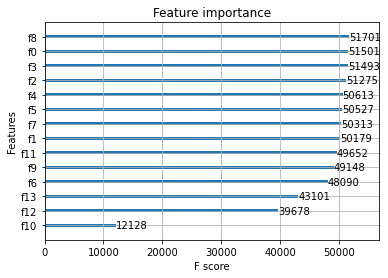

In [49]:
xgb.plot_importance(bst_full)

In [50]:
with open("test2.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Id","Predicted"])
    for i, val in enumerate(pred_xgb_full):
        writer.writerow([i+1, val])